# Define Backtest Logic and Parameters

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('Binance_BTCUSDT_1min.csv')
df = df.iloc[:,:6]
df.columns=['timestamp','open', 'high', 'low', 'close', 'volume']
df.reset_index(drop=True, inplace=True)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index("timestamp")

In [3]:
def resample_df(df, freq):
    resampled_open = df.open.resample(freq).first()
    resampled_high = df.high.resample(freq).max()
    resampled_low = df.low.resample(freq).min()
    resampled_close = df.close.resample(freq).last()
    resampled_volume = df.volume.resample(freq).sum()
    new_df = pd.concat([resampled_open, resampled_high, resampled_low, resampled_close, resampled_volume], axis=1)
    new_df.dropna(inplace=True)
    return new_df

In [4]:
def calc_price(new_df):
    new_df["price"] = new_df.open.shift(-1)

In [5]:
def calc_mtf_ma(new_df, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length):

    fast_ma_df = new_df['close'].resample(fast_ma_freq).last()
    slow_ma_df = new_df['close'].resample(slow_ma_freq).last()

    new_df['fast_ma'] = fast_ma_df.rolling(fast_ma_length).mean()
    new_df['fast_ma'].ffill(inplace=True)
    
    new_df['slow_ma'] = slow_ma_df.rolling(slow_ma_length).mean()
    new_df['slow_ma'].ffill(inplace=True)

In [6]:
def calc_buy_signal(new_df):
    new_df['buy_signal'] = np.where((new_df.fast_ma > new_df.slow_ma) & (new_df.low.shift(1) < new_df.fast_ma) & (new_df.close > new_df.fast_ma), True, False)
    new_df['sell_signal'] = np.where((new_df.fast_ma < new_df.slow_ma) & (new_df.high.shift(1) > new_df.fast_ma) & (new_df.close < new_df.fast_ma), True, False)

In [ ]:
'''
#prepare df
new_df = resample_df(df, "4H")
calc_mtf_ma(new_df, "D", 9 , "W", 9)
calc_buy_signal(new_df)
new_df[new_df.buy_signal == True]
'''

In [ ]:
'''
new_df = resample_df(df, freq)
calc_mtf_ma(new_df, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length)
calc_buy_signal(new_df)
'''


In [ ]:
import plotly.graph_objects as go

bars = 500
cutoff_time = new_df.index[-bars]

# Assuming cutoff_time is defined elsewhere in your code
cutoff_time = new_df.index[-bars]

# Filter the DataFrame based on the cutoff date
df_slice = new_df[new_df.index >= cutoff_time]

# Create a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df_slice.index,
                open=df_slice['open'],
                high=df_slice['high'],
                low=df_slice['low'],
                close=df_slice['close'],
                increasing=dict(line=dict(color='green')),  # Change color for increasing candles
                decreasing=dict(line=dict(color='red')))])  # Change color for decreasing candles

# Add markers for high_range_dev and low_range_dev
high_range_dev = df_slice[df_slice['buy_signal'] == True]
low_range_dev = df_slice[df_slice['buy_signal'] == True]

fig.add_trace(go.Scatter(x=high_range_dev.index,
                         y=high_range_dev['high'],
                         mode='markers',
                         name='Weak resistance',
                         marker=dict(color='blue', size=10)))

fig.add_trace(go.Scatter(x=low_range_dev.index,
                         y=low_range_dev['low'],
                         mode='markers',
                         name='Strong resistance',
                         marker=dict(color='orange', size=10)))

# Update layout
fig.update_layout(title='Candlestick Chart with Range Deviations',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  width=1200,
                  height=900)

# Show the figure
fig.show()


In [7]:
#Prepare DF
new_df = resample_df(df, "2H")
calc_levels(new_df)
is_SFP(new_df)
get_signal(new_df)
new_df.dropna(inplace=True)
new_df

NameError: name 'calc_levels' is not defined

# Backtest

In [61]:
def backtest(df, freq, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length, tp, sl):

    new_df = resample_df(df, freq)
    calc_price(new_df)
    calc_mtf_ma(new_df, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length)
    calc_buy_signal(new_df)
    new_df.dropna(inplace=True)
    
    #Error handle for no buy signals
    if len(new_df[new_df.buy_signal > 0]) | len(new_df[new_df.sell_signal > 0]) < 1:
        empty_result = pd.DataFrame({
            "entry_time": [0],
            "entry_price": [0],
            "tp_target": [0],
            "sl_target": [0],
            "exit_time": [0],
            "exit_price": [0],
            "pnl": [0],
            "equity": [0],
            "pnl_perc": [0]
        })
        amount = 0
        winrate = 0
        cum_pnl_perc = 0
        max_drawdown = 0
        equity_value = 0
        return winrate, amount, cum_pnl_perc, max_drawdown, equity_value
        return empty_result
    
    #Initialise Varibles
    in_sell_position = False
    in_buy_postition = False
    buy_trades = []
    current_buy_trade = {}
    sell_trades = []
    current_sell_trade = {}
    #Need to come back to this logic later, might be a better way to acheive by just append buy & sell data
    initial_equity = 1000
    equity = initial_equity
            
    for i in range(len(new_df)-1):
    #Check exit conditions
        if in_buy_postition:
            if new_df.iloc[i].low < current_buy_trade ["sl_price"]:
                current_buy_trade ["exit_price"] = current_buy_trade ["sl_price"]
                pnl = (current_buy_trade ["exit_price"] - current_buy_trade ["entry_price"])
                pnl_perc = sl - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                buy_trades.append({
                    "entry_time":current_buy_trade ["entry_time"],
                    "entry_price":current_buy_trade ["entry_price"],
                    "side":current_buy_trade["side"],
                    "tp_target":current_buy_trade ["tp_price"],
                    "sl_target":current_buy_trade ["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_buy_trade ["sl_price"],
                    "pnl": pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_buy_trade  = {}
                in_buy_postition = False

            elif new_df.iloc[i].high > current_buy_trade ["tp_price"]:
                current_buy_trade ["exit_price"] = current_buy_trade ["tp_price"]
                pnl = (current_buy_trade ["exit_price"] - current_buy_trade ["entry_price"])
                pnl_perc = tp - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                buy_trades.append({
                    "entry_time":current_buy_trade ["entry_time"],
                    "entry_price":current_buy_trade ["entry_price"],
                    "tp_target":current_buy_trade ["tp_price"],
                    "side":current_buy_trade["side"],
                    "sl_target":current_buy_trade ["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_buy_trade ["tp_price"],
                    "pnl":pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_buy_trade  = {}
                in_buy_postition = False
                
        if in_sell_position:
            if new_df.iloc[i].high > current_sell_trade["sl_price"]:
                current_sell_trade["exit_price"] = current_sell_trade["sl_price"]
                pnl = (current_sell_trade["entry_price"] - current_sell_trade["exit_price"])
                pnl_perc = sl - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                sell_trades.append({
                    "entry_time":current_sell_trade["entry_time"],
                    "entry_price":current_sell_trade["entry_price"],
                    "side":current_sell_trade["side"],
                    "tp_target":current_sell_trade["tp_price"],
                    "sl_target":current_sell_trade["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_sell_trade["sl_price"],
                    "pnl": pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_sell_trade = {}
                in_sell_position = False

            elif new_df.iloc[i].low < current_sell_trade["tp_price"]:
                current_sell_trade["exit_price"] = current_sell_trade["tp_price"]
                pnl = (current_sell_trade["entry_price"] - current_sell_trade["exit_price"])
                pnl_perc = tp - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                sell_trades.append({
                    "entry_time":current_sell_trade["entry_time"],
                    "entry_price":current_sell_trade["entry_price"],
                    "side":current_sell_trade["side"],
                    "tp_target":current_sell_trade["tp_price"],
                    "sl_target":current_sell_trade["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_sell_trade["tp_price"],
                    "pnl":pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_sell_trade = {}
                in_sell_position = False



        #Check entry conditions
        if not in_buy_postition:
            if new_df.iloc[i].buy_signal == True:
                current_buy_trade["entry_price"] = new_df.iloc[i].price
                current_buy_trade["entry_time"] = new_df.iloc[i+1].name
                current_buy_trade["side"] = "long"
                current_buy_trade["tp_price"] = new_df.iloc[i].price*tp
                current_buy_trade["sl_price"] = new_df.iloc[i].price*sl
                #current_trade["base_value"] = trade_amount/new_df.iloc[i].price
                #current_trade["quote_value"] = trade_amount
                in_buy_postition = True

        if not in_sell_position:
            if new_df.iloc[i].sell_signal == True:
                current_sell_trade["entry_price"] = new_df.iloc[i].price
                current_sell_trade["entry_time"] = new_df.iloc[i+1].name
                current_sell_trade["side"] = "short"
                current_sell_trade["tp_price"] = new_df.iloc[i].price*(1-tp+1)
                current_sell_trade["sl_price"] = new_df.iloc[i].price*(1-sl+1)
                #current_trade["base_value"] = trade_amount/new_df.iloc[i].price
                #current_trade["quote_value"] = trade_amount
                in_sell_position = True




    all_trades = buy_trades + sell_trades

    # Convert the concatenated list of trades into a DataFrame
    df_all_trades = pd.DataFrame(all_trades)
    
    # Sort the combined DataFrame by entry_time
    df_all_trades_sorted = df_all_trades.sort_values(by='entry_time')  
    
    data = pd.DataFrame(df_all_trades_sorted)
    amount = len(data)
    winrate = round(len(data.loc[data.pnl.values>0])/len(data)*100,2)
    cum_pnl_perc = round(sum(pd.Series(data.pnl_perc))*100,2)
    equity_value = round(data.equity[len(data) - 1], 2)
    pnl = round(float(data.equity[len(data) - 1]) - initial_equity,2)
    length = data.exit_time[len(data)-1] - data.entry_time[0]
    max_drawdown = 100 - data.equity.min()/initial_equity*100
    equity_high = round(data.equity.max(),2)
    equity_low = round(data.equity.min(),2)

    """
    print(f"Winrate: {winrate}%")
    print(f"Amount of trades: {amount}")
    print(f"Culmulative pnl: {cum_pnl_perc}%")
    print("")
    print(f"Max drawdown: {max_drawdown} %")
    print(f"Equity Max: {equity_high} USD")
    print(f"Equity Min: {equity_low} USD")
    print(f"Final equity value: {equity_value} USD")
    print("")
    print(f"Summary: ${pnl} profit made from ${initial_equity} initial in about {length} hours & minutes")
    """
    return winrate, amount, cum_pnl_perc, max_drawdown, equity_value
    #return data

In [62]:
#backtest(df, freq, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length, tp, sl)
#13272	4H	4H	20	D	10	1.10	0.94	51.94	129	298.0	-10.0	12800.79	1.666667

In [63]:
trades = backtest(df, '4H', "4H", 20, "D", 10, 1.1, 0.94)

In [65]:
trades

(42.62, 244, 200.0, -0.500663999999972, 2883.72)

In [21]:
len(trades)

180

# Visualise Data

In [66]:
#trades = backtest(df, '4H', "4H", 20, "D", 10, 1.1, 0.96)
new_df = resample_df(df, '4H')
calc_price(new_df)
calc_mtf_ma(new_df, "4H", 20, "D", 10)
calc_buy_signal(new_df)
new_df.dropna(inplace=True)
new_df

,open,high,low,close,volume,price,fast_ma,slow_ma,buy_signal
timestamp,,,,,,,,,
2017-08-26 00:00:00,4280.68,4315.00,4228.99,4297.94,41.638568,4297.94,4219.3750,4172.386,False
2017-08-26 04:00:00,4297.94,4319.70,4252.44,4319.70,28.707288,4319.70,4233.3600,4172.386,False
2017-08-26 08:00:00,4319.70,4319.70,4260.88,4288.72,36.153081,4288.72,4242.7755,4172.386,False
2017-08-26 12:00:00,4288.72,4306.74,4221.14,4275.00,34.654984,4275.00,4252.7815,4172.386,False
2017-08-26 16:00:00,4275.00,4351.32,4212.41,4293.52,47.431108,4293.52,4255.5580,4172.386,False
...,...,...,...,...,...,...,...,...,...
2024-03-06 12:00:00,67301.31,67592.31,64664.92,66481.12,21399.964240,66481.12,65061.3845,62060.980,False
2024-03-06 16:00:00,66481.12,67465.00,66221.10,66739.48,10674.762190,66739.49,65306.8035,62060.980,False
2024-03-06 20:00:00,66739.49,67363.58,65714.17,66074.04,7643.203490,66074.04,65502.2740,62060.980,False


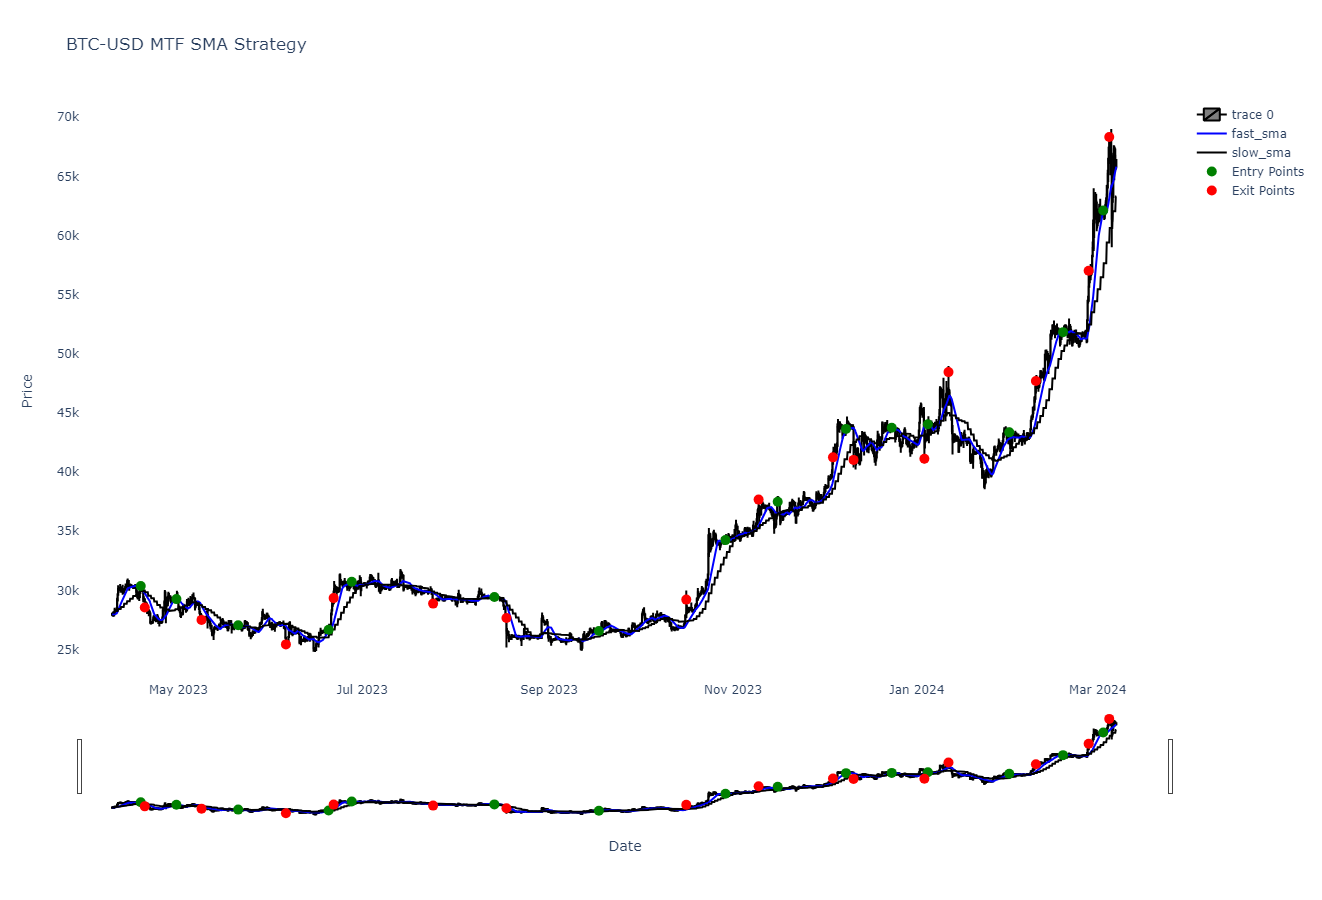

In [101]:
bars = 2000
cutoff_time = new_df.index[-bars]
trades_slice = trades[trades['entry_time'] >= cutoff_time]

# Create a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=new_df.index[-bars:],
                open=new_df['open'].tail(bars),
                high=new_df['high'].tail(bars),
                low=new_df['low'].tail(bars),
                close=new_df['close'].tail(bars),increasing_line_color= 'black', decreasing_line_color= 'black')])

# Add scatter plots for entry and exit points
entry_points = dict(x=trades_slice['entry_time'], y=trades_slice['entry_price'], text=['Buy'] * len(trades_slice), mode='markers', name='Entry Points', marker=dict(color='green', size=10))
exit_points = dict(x=trades_slice['exit_time'], y=trades_slice['exit_price'], text=['Sell'] * len(trades_slice), mode='markers', name='Exit Points', marker=dict(color='red', size=10))

# Add entry and exit points to the figure
#fig.add_trace(go.Scatter(x=new_df.index, y=new_df['pdLow'], mode='lines', name='Previous Day Low'))
fig.add_trace(go.Scatter(x=new_df.index[-bars:], y=new_df['fast_ma'][-bars:], mode='lines', name='fast_sma', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=new_df.index[-bars:], y=new_df['slow_ma'][-bars:], mode='lines', name='slow_sma', line=dict(color='black')))
fig.add_trace(go.Scatter(entry_points))
fig.add_trace(go.Scatter(exit_points))

# Update layout
fig.update_layout(title='BTC-USD MTF SMA Strategy', xaxis_title='Date', yaxis_title='Price', width=1200, height=900, plot_bgcolor='white', yaxis=dict(showgrid=False), xaxis=dict(showgrid=False))

# Show the figure
fig.show()


In [ ]:
plt.plot(trades.equity)

# Adding labels to the x and y axes
plt.xlabel('Amount of trades')
plt.ylabel('Equity Value')

# Display the plot
plt.show()

# Optimise

In [ ]:
#backtest(df, freq, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length, tp, sl)

In [66]:
# Define the parameter combinations
freq_values = ["5T", "30T", "1H", "4H"]
fast_ma_freq_values = ["5T", "30T", "1H", "4H"]
slow_ma_freq_values = ["5T", "30T", "1H", "4H"]
fast_ma_length_values = [5, 10, 20, 50, 100, 200]
slow_ma_length_values = [5, 10, 20, 50, 100, 200]
tp_values = [1.02, 1.03, 1.04, 1.06, 1.08, 1.1]
sl_values = [0.98, 0.97, 0.96, 0.94, 0.92, 0.9]

In [ ]:
# Define the test combinations
freq_values = ["4H"]
fast_ma_freq_values = ["D", "W"]
slow_ma_freq_values = ["D", "W"]
fast_ma_length_values = [50, 100]
slow_ma_length_values = [50, 100]
tp_values = [1.06]
sl_values = [0.94]

In [67]:
results_df = pd.DataFrame(columns=["freq", "fast_ma_freq", "fast_ma_length", "slow_ma_freq", "slow_ma_length", "tp", "sl", "winrate", "amount", "cum_pnl_perc", "max_drawdown", "equity_value"])

In [ ]:
for freq, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length, tp, sl in itertools.product(freq_values, fast_ma_freq_values, fast_ma_length_values, slow_ma_freq_values, slow_ma_length_values, tp_values, sl_values):
    winrate, amount, cum_pnl_perc, max_drawdown, equity_value = backtest(df, freq, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length, tp, sl)
    result = pd.DataFrame([[freq, fast_ma_freq, fast_ma_length, slow_ma_freq, slow_ma_length, tp, sl, winrate, amount, cum_pnl_perc, max_drawdown, equity_value]], columns=["freq", "fast_ma_freq", "fast_ma_length", "slow_ma_freq", "slow_ma_length", "tp", "sl", "winrate", "amount", "cum_pnl_perc", "max_drawdown", "equity_value"])
    try:
        # Concatenate the result DataFrame with the existing results_df
        results_df = pd.concat([results_df, result], ignore_index=True)
    except Exception as e:
        # Handle the exception
        print("An error occurred during concatenation:", e)
        # You can add additional error handling logic here, such as logging the error or performing alternative actions

In [ ]:
results_df

In [17]:
results_df["rr"] = (results_df.tp - 1) / (1 - results_df.sl)


In [90]:
results_df[(results_df["equity_value"]>10000) & (results_df["rr"] > 1.5) & (results_df["winrate"]>50)]

,freq,fast_ma_freq,fast_ma_length,slow_ma_freq,slow_ma_length,tp,sl,winrate,amount,cum_pnl_perc,max_drawdown,equity_value,rr
13197,4H,4H,20,4H,50,1.1,0.94,51.13,133,290.0,-10.0,11695.35,1.666667
13272,4H,4H,20,D,10,1.1,0.94,51.94,129,298.0,-10.0,12800.79,1.666667


In [33]:
results_df['cum_pnl_perc'].max()

424.0

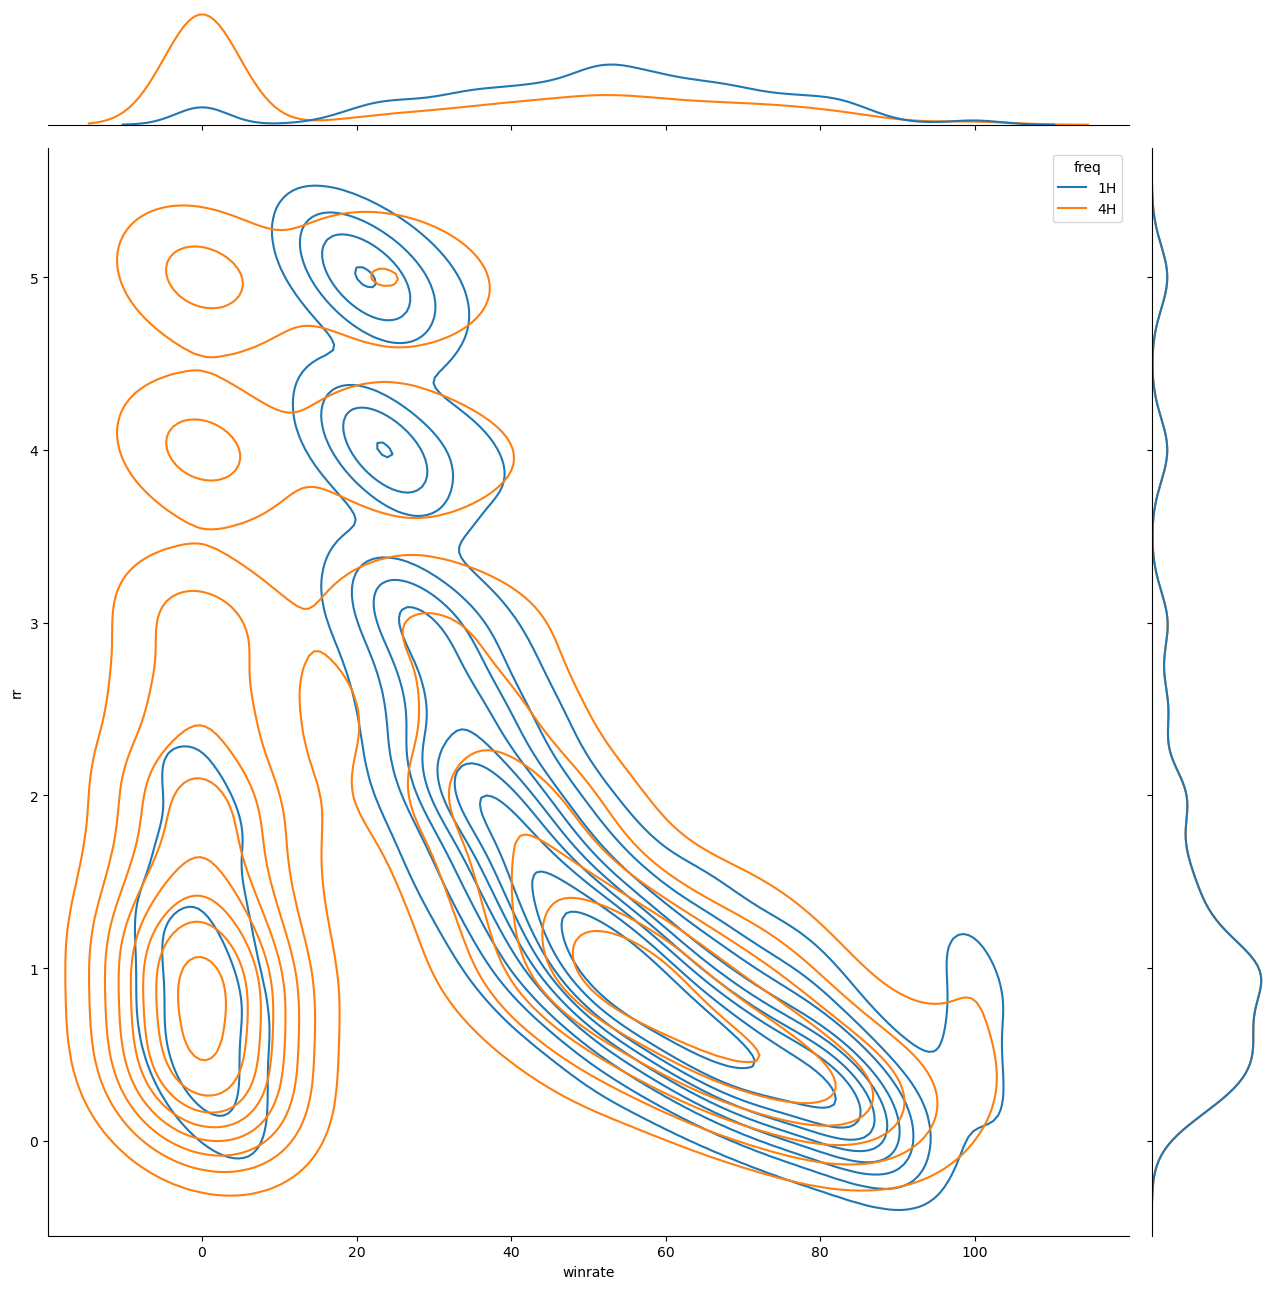

In [38]:
g = sns.jointplot(
    data=results_df,
    x="winrate", y="rr", hue="freq",
    kind="kde", height=13, ratio=8
)